In [21]:
import pandas as pd
from umap import UMAP
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier

DATA_FILE = 'ingredient_data2.csv'

In [22]:
df = pd.read_csv(DATA_FILE)
df.shape

(145087, 15)

In [23]:
# Various experimental dataset modifications

# replaces each quantity with its ratio to flour
df2 = df.copy()
for c in df2.columns:
    if c == 'flour' or c == 'category':
        continue
    df2[c] = df2[c]/df2['flour']
df2.drop(columns='flour', inplace=True)
df2.drop(index=df2.loc[df2['sugar'] > 5].index, inplace=True)
df2.reset_index(drop=True, inplace=True)

# remove likely malformed inputs (recipes that have 5 times as much sugar as flour)
df['s2f'] = df['sugar'] / df['flour']
df.drop(index=df.loc[df['s2f'] > 5].index, inplace=True)
df.drop(columns='s2f', inplace=True)
df.reset_index(drop=True, inplace=True)

# remove muffins
df_no_m = df.drop(index=df.loc[df['category'] == 'muffin'].index).reset_index(drop=True)

# remove recipes with no sugar
df_s = df.drop(index=df.loc[df['sugar'] == 0].index).reset_index(drop=True)

### PCA just to get an idea of the dataset

In [24]:
current_df = df
pca2c = PCA(n_components=2)
mypcs = pd.DataFrame(pca2c.fit_transform(current_df.drop(columns='category')), columns=['pc1', 'pc2'])

<Axes: xlabel='pc1', ylabel='pc2'>

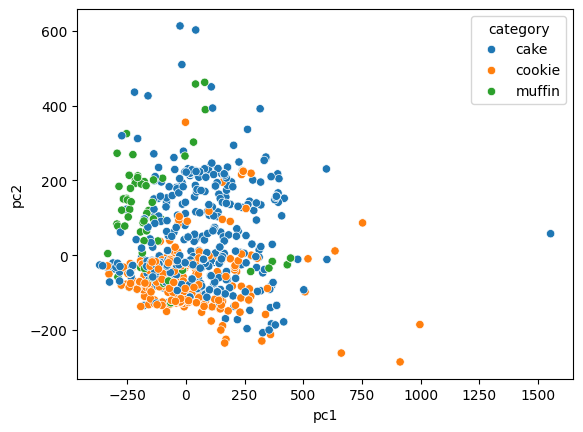

In [25]:
# limited to first 1000 points to reduce clutter
sns.scatterplot(data=mypcs.iloc[:1000], x='pc1', y='pc2', hue=current_df['category'].iloc[:1000])

### UMAP

In [26]:
current_df = df
umaptf = UMAP(min_dist=0.1, n_neighbors=50)
umapembedding = pd.DataFrame(umaptf.fit_transform(current_df.drop(columns='category').iloc[:5000]), columns=['d1', 'd2'])

<Axes: xlabel='d1', ylabel='d2'>

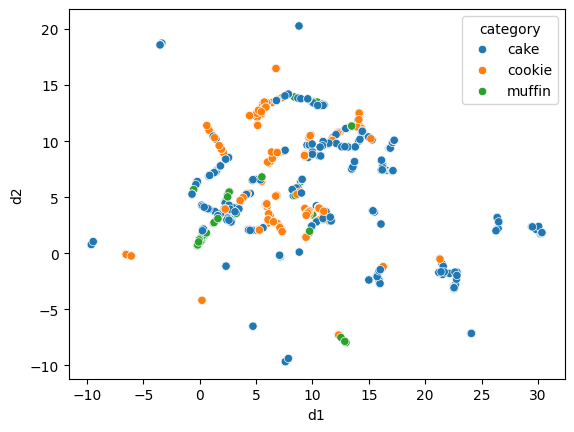

In [13]:
sns.scatterplot(data=umapembedding, x='d1', y='d2', hue=current_df['category'].iloc[:5000])

### Evaluating UMAP with kNN

In [14]:
# kNN without any data transformation, as a control
# uses data points 0-2999 as training, 3000-3999 as test
current_df = df
knn = KNeighborsClassifier(n_neighbors=25, weights='distance').fit(current_df.drop(columns='category').iloc[:3000], current_df['category'].iloc[:3000])
knn.score(current_df.drop(columns='category').iloc[3000:4000], current_df['category'].iloc[3000:4000])

0.837

In [18]:
# transform some data points with UMAP, same train/test as above
current_df = df
umaptf = UMAP(min_dist=0.1, n_neighbors=70, random_state=99, n_jobs=1)
transformer = umaptf.fit(current_df.drop(columns='category').iloc[:3000])
embedding = transformer.transform(current_df.drop(columns='category').iloc[3000:4000])

In [19]:
# evaluate UMAP embedding with kNN
knn = KNeighborsClassifier(n_neighbors=15, weights='distance').fit(transformer.embedding_, current_df['category'].iloc[:3000])
knn.score(embedding, current_df['category'].iloc[3000:4000])

0.814

This is lower than the plain kNN score, but it's still pretty good when you consider it in terms of how it compresses the original data down to 2 dimensions

### t-SNE

<Axes: xlabel='d1', ylabel='d2'>

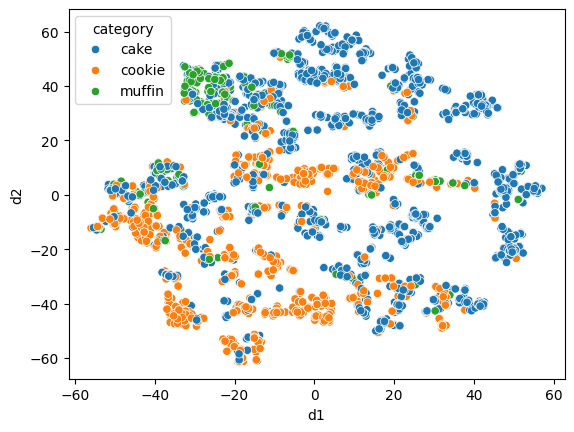

In [20]:
current_df = df
tsne_model = TSNE(n_components=2, perplexity=50)
tse = tsne_model.fit_transform(current_df.drop(columns='category').iloc[:5000])
tse = pd.DataFrame(tse, columns=['d1','d2'])
sns.scatterplot(data=tse, x='d1', y='d2', hue=current_df['category'])

## Evaluating PCA, UMAP, and t-SNE with silhouette score and ARI

In [28]:
from sklearn.metrics import adjusted_rand_score, silhouette_score

### Silhouette scores

In [29]:
current_df = df

print('2d PCA silhouette score:')
print(silhouette_score(X=mypcs.iloc[:5000], labels=current_df['category'].iloc[:5000]))

print('UMAP silhouette score:')
print(silhouette_score(X=umapembedding, labels=current_df['category'].iloc[:5000]))

print('t-SNE silhouette score:')
print(silhouette_score(X=tse, labels=current_df['category'].iloc[:5000]))

2d PCA silhouette score:
0.04278151389636587
UMAP silhouette score:
-0.12163689
t-SNE silhouette score:
0.0022150672


### kNN and adjusted Rand index

In [35]:
import warnings
warnings.filterwarnings("ignore")

current_df = df

pca_transformer = PCA(n_components=2).fit(current_df.drop(columns='category').iloc[:5000])
pca_train_embedding = pca_transformer.transform(current_df.drop(columns='category').iloc[:5000])
pca_test_embedding = pca_transformer.transform(current_df.drop(columns='category').iloc[5000:7000])
pca_knn = KNeighborsClassifier(n_neighbors=15).fit(pca_train_embedding, current_df['category'].iloc[:5000])
knn_test_pred = pca_knn.predict(pca_test_embedding)

no_dr_knn = KNeighborsClassifier(n_neighbors=15).fit(current_df.drop(columns='category').iloc[:5000], 
                                                     current_df['category'].iloc[:5000])
no_dr_knn_pred = no_dr_knn.predict(current_df.drop(columns=['category']).iloc[5000:7000])

umap_model = UMAP(min_dist=0.1, n_neighbors=50, random_state=99, n_jobs=1)
umap_transformer = umap_model.fit(current_df.drop(columns='category').iloc[:5000])
umap_test_embedding = umap_transformer.transform(current_df.drop(columns='category').iloc[5000:7000])
umap_knn = KNeighborsClassifier(n_neighbors=15, weights='distance').fit(umap_transformer.embedding_, 
                                                                        current_df['category'].iloc[:5000])
umap_knn_pred = umap_knn.predict(umap_test_embedding)

print('2-D PCA + kNN, adjusted Rand index:')
print(adjusted_rand_score(current_df['category'].iloc[5000:7000], knn_test_pred))

print('kNN w/o dim reduction, adjusted Rand index:')
print(adjusted_rand_score(current_df['category'].iloc[5000:7000], no_dr_knn_pred))

print('UMAP + kNN, adjusted Rand index:')
print(adjusted_rand_score(current_df['category'].iloc[5000:7000], umap_knn_pred))

2-D PCA + kNN, adjusted Rand index:
0.340675938219707
kNN w/o dim reduction, adjusted Rand index:
0.523566902614766
UMAP + kNN, adjusted Rand index:
0.48453393771033726
